### Perspective PS6

In [1]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
biden = pd.read_csv("biden.csv")

In [2]:
biden.head()

biden  female  age  educ  dem  rep
0     90       0   19    12    1    0
1     70       1   51    14    1    0
2     60       0   27    14    0    0
3     50       1   43    14    1    0
4     60       1   38    14    0    1

In [3]:
biden.isnull().sum()

biden     0
female    0
age       0
educ      0
dem       0
rep       0
dtype: int64

In [4]:
# a). 
X = biden.iloc[:, 1:]
y = biden.biden
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25)

In [5]:
biden_tree = DecisionTreeRegressor(max_depth=5, min_samples_leaf=3)
biden_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

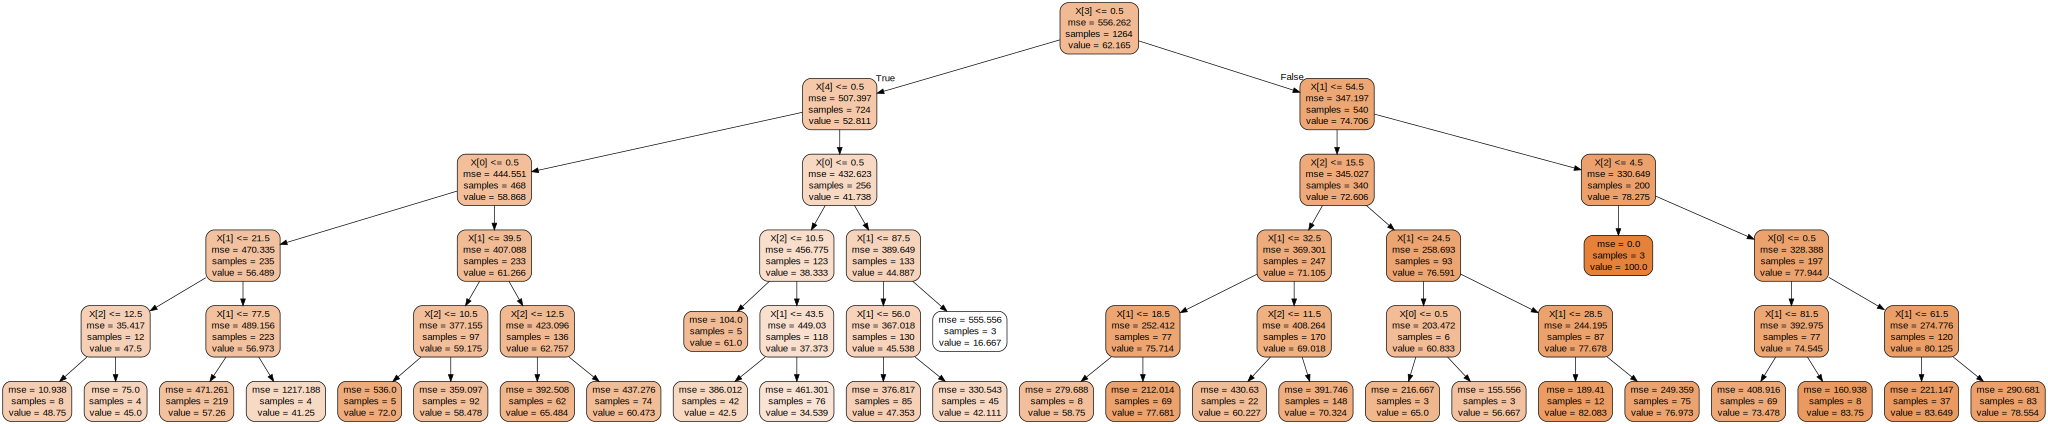

In [6]:
from sklearn.tree import export_graphviz
import graphviz
biden_viz = export_graphviz(
    biden_tree,
    out_file= None,
    rounded=True,
    filled=True)

graph = graphviz.Source(biden_viz)
graph.render('biden_viz')
graph

For simplicity, the top three levels are explained here and the followings can be interpret in the same way. The data will first split according the feature "dem". A Democrat is more likely to like Biden. The expected feeling thermometer is 74.706 for a Democrat and 52.811 for a non-Democrat. For non-Democrats, the data will split according whether the person is a Republican, and a non-republican & non-democrat is more likely to like Biden than a republican. For both the Republicans and the non-Democrat & non-Republicans, the next cut happens at whether the person is female. For both groups, females like Biden better than non-females.

For Democrats, the next split is determined by age. People older than 54.5 like Biden than the younger group. The relavant feature for the next split is education level. For people younger than 54.5, more educated people tends to like Biden more than the less educated ones (cutoff = 15.5 years of formal education); whereas for people older than 54.5, female is more likely to like Biden. 


In [7]:
from sklearn.metrics import mean_squared_error
y_pred = biden_tree.predict(X_test)
MSE1 = mean_squared_error(y_test, y_pred)
print('test MSE for part a', MSE1)

test MSE for part a 406.672049146


In [8]:
# b). 
for depth in range(1,15):
    biden_tree = DecisionTreeRegressor(max_depth=depth, min_samples_leaf=5)
    biden_tree.fit(X_train, y_train)
    y_pred = biden_tree.predict(X_test)
    MSE = mean_squared_error(y_test, y_pred)
    print('with max_depth {}, MSE ={}'.format(depth, MSE))

with max_depth 1, MSE =420.0224529349668
with max_depth 2, MSE =400.06539818418173
with max_depth 3, MSE =396.1937146321307
with max_depth 4, MSE =404.59602362340974
with max_depth 5, MSE =411.80592737244535
with max_depth 6, MSE =420.7201303515671
with max_depth 7, MSE =437.8869249136812
with max_depth 8, MSE =462.7752812506661
with max_depth 9, MSE =462.3674415271974
with max_depth 10, MSE =470.27700924250536
with max_depth 11, MSE =470.9931084565257
with max_depth 12, MSE =480.7842360442156
with max_depth 13, MSE =477.16079264127467
with max_depth 14, MSE =482.051775353099


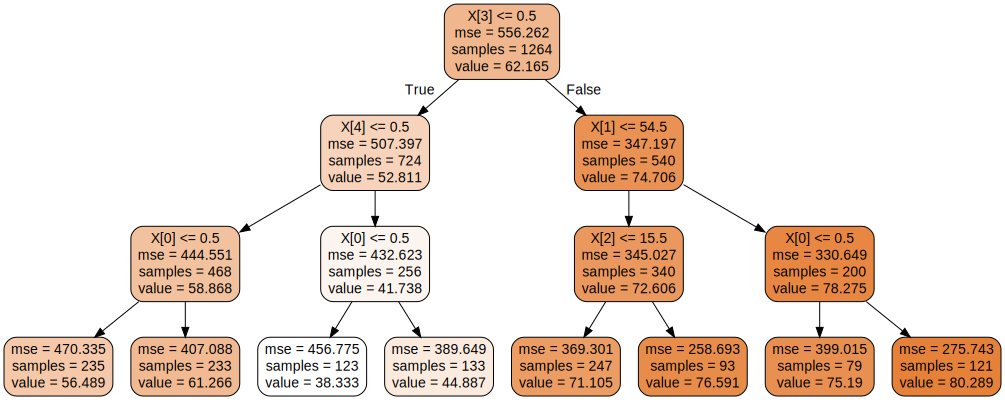

In [9]:
# Since when the max_depth =3 we have the smallest MSE, we set the turning parameter as 3. 
biden_tree2 = DecisionTreeRegressor(min_samples_leaf=5, max_depth=3)
biden_tree2.fit(X_train, y_train)
# map the tree visualization
biden_tree_viz = export_graphviz(biden_tree2, out_file=None, rounded=True, filled=True)
graph = graphviz.Source(biden_tree_viz)
graph.render('biden_tree')
graph

In [10]:
y_pred = biden_tree2.predict(X_test)
MSE2 = mean_squared_error(y_test, y_pred)
print('MSE=', MSE2)

MSE= 396.193714632


The first split is whether a person is a democrat. A democrat is more likely to like Biden than a non-democrat. The feeling thermometer for democrat is 74.76 and for a non-democrat is 52.81. For a non-democrat, if the person is a republican, the likelihood of liking Biden is higher. For a democrat, the next feature that determines the split is age. Aged people tend to like Biden. As the MSE in this part is 396.193, it is improved. 

In [11]:
# c). 
from sklearn.ensemble import BaggingRegressor
biden_tree3 = BaggingRegressor(DecisionTreeRegressor(), n_estimators=100,
                             max_samples=100, bootstrap=True, oob_score=True, random_state=25)
biden_tree3.fit(X, y)

BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=100, n_estimators=100, n_jobs=1, oob_score=True,
         random_state=25, verbose=0, warm_start=False)

In [12]:
importances = np.mean([tree.feature_importances_ for tree in biden_tree3.fit(X, y).estimators_], axis = 0)
print(importances)
#std = np.std([tree.feature_importances_ for tree in biden_tree3.estimators_], axis=0)
print(X.columns)
indices = np.argsort(importances)[::-1]
print(indices)
#print([tree.feature_importances_ for tree in biden_tree3.fit(X, y).estimators_])
# Print the feature ranking
print("Feature ranking:")

features = biden.columns[1:]
for f in range(X.shape[1]):
    print(str(f+1), ". ", features[indices[f]], ": ", str(importances[indices[f]]))

[ 0.05825803  0.44042397  0.20490324  0.18408625  0.11232851]
Index(['female', 'age', 'educ', 'dem', 'rep'], dtype='object')
[1 2 3 4 0]
Feature ranking:
1 .  age :  0.440423969063
2 .  educ :  0.204903241609
3 .  dem :  0.184086250978
4 .  rep :  0.112328510305
5 .  female :  0.0582580280448


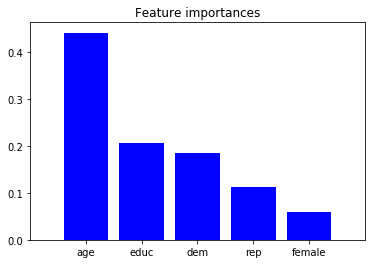

In [13]:
# Plot the feature importances of the forest
import matplotlib.pyplot as plt
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="b", align="center")
plt.xticks(range(X.shape[1]), features[indices])
plt.xlim([-1, X.shape[1]])
plt.show()

In [14]:
y_pred3 = biden_tree3.predict(X)
MSE3 = mean_squared_error(y, y_pred3)
print('test MSE for part c', MSE3)

test MSE for part c 363.100064029


From the graph we can see that age is the most significant factor to determine the split of data.

In [15]:
# d). 
from sklearn.ensemble import RandomForestRegressor

indices = []
for m in range(1, 4):
    biden_tree4 = RandomForestRegressor(n_estimators=53, max_features=m, bootstrap=True,
                                  oob_score=True, random_state=15)
    biden_tree4.fit(X, y)
    biden_tree4.score(X, y)
    y_pred4 = biden_tree4.oob_prediction_
    importances = biden_tree4.feature_importances_
    #print(importances)
    indices = np.argsort(importances)[::-1]
    #indices.append(np.argsort(importances)[::-1])
    print("Feature ranking for m = {}:".format(m))
    features = biden.columns[1:]
    for f in range(X.shape[1]):
        print(str(f+1), ". ", features[indices[f]], ": ",str(importances[indices[f]]))
    y_pred4 = biden_tree4.oob_prediction_
    MSE4 = mean_squared_error(y, y_pred4)
    print('test MSE for m = {}'.format(MSE4))
    print()

    

Feature ranking for m = 1:
1 .  age :  0.512175098628
2 .  dem :  0.192432071629
3 .  educ :  0.150180547154
4 .  rep :  0.123879218183
5 .  female :  0.0213330644052
test MSE for m = 532.8750579722736

Feature ranking for m = 2:
1 .  age :  0.50758431124
2 .  dem :  0.191943514043
3 .  educ :  0.151423695616
4 .  rep :  0.127943907267
5 .  female :  0.021104571834
test MSE for m = 538.192542935064

Feature ranking for m = 3:
1 .  age :  0.484652036367
2 .  dem :  0.199165322239
3 .  educ :  0.165089462362
4 .  rep :  0.123722379345
5 .  female :  0.0273707996866
test MSE for m = 535.7619627008756



We can see from the tables above, across all m =1,2,3, age is the most important variable, dem, education and rep follows, female is the less important. The choice of m makes small differences of the test MSE, and when m =1, we have the smallest MSE. 